In [1]:
import sys
sys.path.append('..')
import torch
import os
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from models.CycleGAN import *
from datasets.UnalignedDataset import UnalignedDataset
from utils.utils import ImageBuffer, set_requires_grad, tensor_to_image, save_cyclegan_model, get_activation, get_norm_module, Identity

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
class AdaLIN(nn.Module):
    
    def __init__(self, num_features, eps=1e-5):
        super(AdaLIN, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.rho = nn.Parameter(torch.empty(1, num_features, 1, 1))
        self.rho.data.fill_(0.9)
    
    def forward(self, inputs, gamma, beta):
        #inputs_in_mean, inputs_in_var = torch.mean(inputs, dim=[2, 3], keep_dim=True), torch.var(inputs, dim=[2, 3], keep_dim=True)
        inputs_in_mean = torch.mean(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in_var = torch.var(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in = (inputs - inputs_in_mean) / torch.sqrt((inputs_in_var + self.eps))
        #inputs_ln_mean, inputs_ln_var = torch.mean(inputs, dim[1, 2, 3], keep_dim=True), torch.var(inputs, dim=[1, 2, 3], keep_dim=True)
        inputs_ln_mean = torch.mean(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln_var = torch.var(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln = (inputs - inputs_ln_mean) / torch.sqrt((inputs_ln_var + self.eps))
        
        out = self.rho.expand(inputs.shape[0], -1, -1, -1) * inputs_in + \
              ((1 - self.rho).expand(inputs.shape[0], -1, -1, -1) * inputs_ln)
        
        return gamma.unsqueeze(2).unsqueeze(3) * out + beta.unsqueeze(2).unsqueeze(3)

In [3]:
class LIN(nn.Module):
    
    def __init__(self, num_features, eps=1e-5):
        super(LIN, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.rho = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.gamma = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.rho.data.fill_(0.0)
        self.gamma.data.fill_(1.0)
        self.beta.data.fill_(0.0)
    
    def forward(self, inputs):
        #inputs_in_mean, inputs_in_var = torch.mean(inputs, dim=[2, 3], keep_dim=True), torch.var(inputs, dim=[2, 3], keep_dim=True)
        inputs_in_mean = torch.mean(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in_var = torch.var(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in = (inputs - inputs_in_mean) / torch.sqrt((inputs_in_var + self.eps))
        #inputs_ln_mean, inputs_ln_var = torch.mean(inputs, dim[1, 2, 3], keep_dim=True), torch.var(inputs, dim=[1, 2, 3], keep_dim=True)
        inputs_ln_mean = torch.mean(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln_var = torch.var(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln = (inputs - inputs_ln_mean) / torch.sqrt((inputs_ln_var + self.eps))
        
        out = self.rho.expand(inputs.shape[0], -1, -1, -1) * inputs_in + \
                ((1 - self.rho).expand(inputs.shape[0], -1, -1, -1) * inputs_ln)
        
        return self.gamma.expand(inputs.shape[0], -1, -1, -1) * out + self.beta.expand(inputs.shape[0], -1, -1, -1)

In [4]:
class AdaLINResBlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size, activation, pad_type):
        super(AdaLINResBlock, self).__init__()
        
        if pad_type == "reflection":
            self.pad1 = nn.ReflectionPad2d(kernel_size // 2)
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
            self.pad2 = nn.ReflectionPad2d(kernel_size // 2)
            self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
        elif pad_type == "zeros":
            self.pad1 = None
            self.pad2 = None
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, padding=kernel_size//2)
            self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, padding=kernel_size//2)
            
        self.norm1 = AdaLIN(in_channels)
        self.norm2 = AdaLIN(in_channels)
        self.act = get_activation(activation)
    
    def forward(self, inputs, gamma, beta):
        out = inputs
        if self.pad1 is not None:
            out = self.pad1(out)
        out = self.conv1(out)
        out = self.act(self.norm1(out, gamma, beta))
        if self.pad2 is not None:
            out = self.pad2(out)
        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)
        return out + inputs
        
    

In [5]:
class UpsampleConvBlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size, activation, norm_type, pad_type):
        super(UpsampleConvBlock, self).__init__()
        
        if pad_type == "reflection":
            self.pad = nn.ReflectionPad2d(kernel_size // 2)
            self.conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2,
                              kernel_size=kernel_size)
        elif pad_type == "zeros":
            self.pad = None
            self.conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2,
                              kernel_size=kernel_size, padding=kernel_size//2)
        
        self.act = get_activation(activation)
        self.upsample = nn.Upsample(scale_factor=2)
        self.norm = get_norm_module(norm_type)(in_channels//2)
    
    def forward(self, inputs):
        out = self.upsample(inputs)
        if self.pad is not None:
            out = self.pad(out)
        out = self.conv(out)
        out = self.norm(out)
        out = self.act(out)
        return out 

In [6]:
class Generator(nn.Module):
    
    def __init__(self, in_channels, img_size, num_enc_blocks, num_enc_res_blocks, num_dec_upsample_blocks,
                 num_dec_res_blocks, norm_type, pad_type):
        super(Generator, self).__init__()
        
        dims = 32
        self.conv1 = ConvNormRelu(in_channels=in_channels, out_channels=dims, kernel_size=7, padding=(3, pad_type),
                                  norm=norm_type, leaky=False)
        
       # self.conv1_5 = ConvNormRelu(in_channels=64, out_channels=dims, kernel_size=7, padding=(3, pad_type),
        #                           norm=norm_type, leaky=False)
        
        self.convs = nn.ModuleList()
        
        for _ in range(num_enc_blocks - 1):
            prev_dims = dims
            dims = min(dims * 2, 256)
            self.convs.append(ConvNormRelu(in_channels=prev_dims, out_channels=dims, kernel_size=3,
                                           padding=(1, pad_type), norm=norm_type, stride=2))
            
        self.res_blocks = nn.ModuleList()
        
        for _ in range(num_enc_res_blocks):
            self.res_blocks.append(ResBlock(in_planes=dims, kernel_size=3, padding=(1, pad_type), norm=norm_type))
            
        
        self.gap_fc = nn.Linear(dims, 1)
        self.gmp_fc = nn.Linear(dims, 1)
        self.conv2 = nn.Conv2d(in_channels=dims * 2, out_channels=dims, kernel_size=1, stride=1)
        
        
#         MLP = [nn.Linear(in_features=dims * (img_size // 2 ** (num_enc_blocks - 1)) ** 2, out_features=dims),
#                nn.ReLU(True),
#                nn.Linear(in_features=dims, out_features=dims),
#                nn.ReLU(True)]
        
        MLP = [nn.Linear(in_features=dims, out_features=dims),
               nn.ReLU(True),
               nn.Linear(in_features=dims, out_features=dims),
               nn.ReLU(True)]
        
        self.mlp = nn.Sequential(*MLP)
        self.gamma = nn.Linear(in_features=dims, out_features=dims)
        self.beta = nn.Linear(in_features=dims, out_features=dims)
        
        #Decoder
        self.decoder_res_blocks = nn.ModuleList()
        for _ in range(num_dec_res_blocks):
            self.decoder_res_blocks.append(AdaLINResBlock(in_channels=dims, kernel_size=3,
                                                      activation='relu', pad_type="reflection"))
        
        self.upsample_blocks = nn.ModuleList()
        for _ in range(num_dec_upsample_blocks):
            self.upsample_blocks.append(UpsampleConvBlock(in_channels=dims, kernel_size=3, activation="relu",
                                                         norm_type="lin", pad_type="reflection"))
            dims = dims // 2
        
        self.pad_last_conv = nn.ReflectionPad2d(3)
        self.last_conv = nn.Conv2d(in_channels=dims, out_channels=3, kernel_size=7, stride=1)
        
    
    def forward(self, inputs):
        #print(list(self.gap_fc.parameters())[0].shape)
        #Extracting features
        out = self.conv1(inputs)
        #out = self.conv1_5(out)
        
        for conv in self.convs:
            out = conv(out)
            
        for res_block in self.res_blocks:
            out = res_block(out)
            
            
        #Global Average and Max Pooling
        gap = F.adaptive_avg_pool2d(out, 1)
        gap_logits = self.gap_fc(gap.view(out.shape[0], -1))
        gap_fc_weigths = list(self.gap_fc.parameters())[0]
        gap = gap_fc_weigths.view(gap_fc_weigths.size(0), gap_fc_weigths.size(1), 1, 1) * out
        
        
        gmp = F.adaptive_max_pool2d(out, 1)
        gmp_logits = self.gmp_fc(gmp.view(out.shape[0], -1))
        gmp_fc_weights = list(self.gmp_fc.parameters())[0]
        gmp = gmp_fc_weights.view(gmp_fc_weights.size(0), gmp_fc_weights.size(1), 1, 1) * out
        
        gmp_gap_logits = torch.cat([gmp_logits, gap_logits], 1)
        
        gmp_gap = torch.cat([gmp, gap], 1)
        
        out = F.relu(self.conv2(gmp_gap))
        cam = out
        
        #Calculating beta and gamma for AdaLIN
        out = F.adaptive_avg_pool2d(out, 1)
        out = self.mlp(out.view(out.size(0), -1))
        
        gamma = self.gamma(out)
        beta = self.beta(out)
        
        out = cam
        for res_block in self.decoder_res_blocks:
            out = res_block(out, gamma, beta)
        
        for upsample_block in self.upsample_blocks:
            out = upsample_block(out)
        
        out = self.pad_last_conv(out)
        return F.tanh(self.last_conv(out)), gmp_gap_logits

In [7]:
class ConvSpectralNormAct(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, activation):
        super(ConvSpectralNormAct, self).__init__()
        if padding[1] == "reflection":
            self.pad = nn.ReflectionPad2d(padding[0])
            self.conv = nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                 stride=stride))
        elif padding[1] == "zeros":
            self.pad = None
            self.conv = nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                                 padding=padding[0], stride=stride))
        
        self.act = get_activation(activation)
        
    def forward(self, inputs):
        out = inputs
        if self.pad is not None:
            out = self.pad(out)
        out = self.conv(out)
        return self.act(out)

In [8]:
class PatchGan(nn.Module):
    
    def __init__(self, in_channels, num_downsample, pad_type):
        super(PatchGan, self).__init__()
        
        dims = 32
        self.conv1 = ConvSpectralNormAct(in_channels=in_channels, out_channels=dims, kernel_size=4,
                                  padding=(1, pad_type), stride=2, activation="lrelu")
        
        #self.conv1_5 = ConvSpectralNormAct(in_channels=64, out_channels=dims, kernel_size=4,
                           #       padding=(1, pad_type), stride=2, activation="lrelu")
        
        self.convs = nn.ModuleList()
        for _ in range(num_downsample - 1):
            prev_dims = dims
            dims = dims * 2
            self.convs.append(ConvSpectralNormAct(in_channels=prev_dims, out_channels=dims, kernel_size=4,
                                  padding=(1, pad_type), stride=2, activation="lrelu"))
        
        prev_dims = dims
        dims = dims * 2
        
        self.conv2 = ConvSpectralNormAct(in_channels=prev_dims, out_channels=dims, kernel_size=4,
                                  padding=(1, pad_type), stride=1, activation="lrelu")
        
        self.gap_fc = nn.utils.spectral_norm(nn.Linear(dims, 1, bias=False))
        self.gmp_fc = nn.utils.spectral_norm(nn.Linear(dims, 1, bias=False))
        self.conv3 = nn.Conv2d(in_channels=dims * 2, out_channels=dims, kernel_size=1, stride=1, padding=0)
        
        self.pad_last_conv = nn.ReflectionPad2d(1)
        self.last_conv = nn.utils.spectral_norm(nn.Conv2d(in_channels=dims, out_channels=1, kernel_size=4, stride=1))
    
    
    def forward(self, inputs):
        #print(list(self.gap_fc.parameters())[0].shape)
        out = self.conv1(inputs)
       # out = self.conv1_5(out)
        for conv in self.convs:
            out = conv(out)
        out = self.conv2(out)
        
        gap = F.adaptive_avg_pool2d(out, 1)
        gap_logits = self.gap_fc(gap.view(gap.size(0), -1))
        gap_fc_weights = list(self.gap_fc.parameters())[0]
        #print(gap_fc_weights.shape)
        gap = out * gap_fc_weights.view(gap_fc_weights.size(0), gap_fc_weights.size(1), 1, 1)
        

        gmp = F.adaptive_max_pool2d(out, 1)
        gmp_logits = self.gmp_fc(gmp.view(gmp.size(0), -1))
        gmp_fc_weights = list(self.gmp_fc.parameters())[0]
        gmp = out * gmp_fc_weights.view(gmp_fc_weights.size(0), gmp_fc_weights.size(1), 1, 1)
        
        
        gap_gmp_logits = torch.cat([gap_logits, gmp_logits], 1)
        gap_gmp = torch.cat([gap, gmp], 1)
        
        out = F.leaky_relu(self.conv3(gap_gmp), negative_slope=0.2)
        
        out = self.pad_last_conv(out)
        out = self.last_conv(out)
        
        return out, gap_gmp_logits

In [9]:
class RhoClipper(object):

    def __init__(self, min, max):
        self.clip_min = min
        self.clip_max = max
        assert min < max

    def __call__(self, module):

        if hasattr(module, 'rho'):
            w = module.rho.data
            w = w.clamp(self.clip_min, self.clip_max)
            module.rho.data = w

In [10]:
class UGATIT(nn.Module):
    
    
    def __init__(self, in_channels, img_size, num_enc_blocks, num_enc_res_blocks, num_dec_upsample_blocks,
                 num_dec_res_blocks, norm_type, pad_type, local_discr_num_downsample, global_discr_num_downsample):
        super(UGATIT, self).__init__()
        
        self.G_AB = Generator(in_channels, img_size, num_enc_blocks, num_enc_res_blocks,
                            num_dec_upsample_blocks, num_dec_res_blocks, norm_type, pad_type)
        
        self.G_BA = Generator(in_channels, img_size, num_enc_blocks, num_enc_res_blocks,
                            num_dec_upsample_blocks, num_dec_res_blocks, norm_type, pad_type)
        
        self.D_AG = PatchGan(in_channels, num_downsample=global_discr_num_downsample, pad_type=pad_type)
        self.D_AL = PatchGan(in_channels, num_downsample=local_discr_num_downsample, pad_type=pad_type)
        
        self.D_BG = PatchGan(in_channels, num_downsample=global_discr_num_downsample, pad_type=pad_type)
        self.D_BL = PatchGan(in_channels, num_downsample=local_discr_num_downsample, pad_type=pad_type)
        self.rho_clipper = RhoClipper(0, 1)
    
    def forward(self, domain_A, domain_B):
        
        fake_B, logits_cam_AB = self.G_AB(domain_A)
        fake_A, logits_cam_BA = self.G_BA(domain_B)
        
        return fake_A, fake_B
    
    def backward_Gs(self, domain_A, domain_B):
        
        fake_B, logits_cam_AB = self.G_AB(domain_A)
        fake_A, logits_cam_BA = self.G_BA(domain_B)
        
        D_AG_out_fake, D_AG_logits_fake = self.D_AG(fake_A)
        D_AL_out_fake, D_AL_logits_fake = self.D_AL(fake_A)
        
        D_AG_out_real, D_AG_logits_real = self.D_AG(domain_A)
        D_AL_out_real, D_AL_logits_real = self.D_AL(domain_A)
        
        D_BG_out_fake, D_BG_logits_fake = self.D_BG(fake_B)
        D_BL_out_fake, D_BL_logits_fake = self.D_BL(fake_B)
        
        D_BG_out_real, D_BG_logits_real = self.D_BG(domain_B)
        D_BL_out_real, D_BL_logits_real = self.D_BL(domain_B)
        
        
        rec_A, _ = self.G_BA(fake_B)
        rec_B, _ = self.G_AB(fake_A)
        
        id_A, logits_cam_AA = self.G_BA(domain_A)
        id_B, logits_cam_BB = self.G_AB(domain_B)
        
        
        #Adversarial loss for fake_A
        adv_loss_A = (calc_mse_loss(D_AG_out_fake, 1.0) + calc_mse_loss(D_AL_out_fake, 1.0) + \
                     calc_mse_loss(D_AG_out_real, 0.0) + calc_mse_loss(D_AL_out_real, 0.0))
        
        #Adversarial loss for fake_B
        adv_loss_B = (calc_mse_loss(D_BG_out_fake, 1.0) + calc_mse_loss(D_BL_out_fake, 1.0) + \
                     calc_mse_loss(D_BG_out_real, 0.0) + calc_mse_loss(D_BL_out_real, 0.0))
        
        #Cycle loss for domain_A and domain_B
        
        cycle_loss_ABA = F.l1_loss(rec_A, domain_A)
        cycle_loss_BAB = F.l1_loss(rec_B, domain_B)
        
        #Identity loss
        
        identity_loss_A = F.l1_loss(id_A, domain_A)
        
        
        identity_loss_B = F.l1_loss(id_B, domain_B)
        
        #CAM Loss
        cam_loss_AB = F.binary_cross_entropy_with_logits(logits_cam_AB, torch.ones_like(logits_cam_AB).cuda()) + \
                        F.binary_cross_entropy_with_logits(logits_cam_BB, torch.zeros_like(logits_cam_BB).cuda())
        
        cam_loss_BA = F.binary_cross_entropy_with_logits(logits_cam_BA, torch.ones_like(logits_cam_BA).cuda()) + \
                        F.binary_cross_entropy_with_logits(logits_cam_AA, torch.zeros_like(logits_cam_AA).cuda())
        
        cam_d_loss_A = calc_mse_loss(D_AG_logits_fake, 1.0) + calc_mse_loss(D_AL_logits_fake, 1.0)
        
        cam_d_loss_B = calc_mse_loss(D_BG_logits_fake, 1.0) + calc_mse_loss(D_BL_logits_fake, 1.0)
        
        loss = 1000 * (cam_loss_AB + cam_loss_BA) + 10 * (identity_loss_A + identity_loss_B) + \
                10 * (cycle_loss_ABA + cycle_loss_BAB) + (adv_loss_A + adv_loss_B + cam_d_loss_A + cam_d_loss_B)
        
        loss.backward()
        
        return loss
    
    
    def backward_Ds(self, domain_A, domain_B):
        
        fake_B, logits_cam_AB = self.G_AB(domain_A)
        fake_A, logits_cam_BA = self.G_BA(domain_B)
        
        D_AG_out_fake, D_AG_logits_fake = self.D_AG(fake_A.detach())
        D_AL_out_fake, D_AL_logits_fake = self.D_AL(fake_A.detach())
        
        D_AG_out_real, D_AG_logits_real = self.D_AG(domain_A)
        D_AL_out_real, D_AL_logits_real = self.D_AL(domain_A)
        
        D_BG_out_fake, D_BG_logits_fake = self.D_BG(fake_B.detach())
        D_BL_out_fake, D_BL_logits_fake = self.D_BL(fake_B.detach())
        
        D_BG_out_real, D_BG_logits_real = self.D_BG(domain_B)
        D_BL_out_real, D_BL_logits_real = self.D_BL(domain_B)
        
        cam_d_loss_A = calc_mse_loss(D_AG_logits_fake, 0.0) + calc_mse_loss(D_AL_logits_fake, 0.0) + \
                        calc_mse_loss(D_AG_logits_real, 1.0) + calc_mse_loss(D_AL_logits_real, 1.0)
        
        cam_d_loss_B = calc_mse_loss(D_BG_logits_fake, 0.0) + calc_mse_loss(D_BL_logits_fake, 0.0) + \
                        calc_mse_loss(D_BG_logits_real, 1.0) + calc_mse_loss(D_BL_logits_real, 1.0)
        
        adv_loss_d_A = calc_mse_loss(D_AG_out_fake, 0.0) + calc_mse_loss(D_AL_out_fake, 0.0) + \
                        calc_mse_loss(D_AG_out_real, 1.0) + calc_mse_loss(D_AL_out_real, 1.0)
        
        adv_loss_d_B = calc_mse_loss(D_BG_out_fake, 0.0) + calc_mse_loss(D_BL_out_fake, 0.0) + \
                        calc_mse_loss(D_BG_out_real, 1.0) + calc_mse_loss(D_BL_out_real, 1.0)
        
        loss = cam_d_loss_A + cam_d_loss_B + adv_loss_d_A + adv_loss_d_B
        
        loss.backward()
        
        return loss

In [11]:
def init_weights_normal(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)

In [12]:
transform = transforms.Compose([transforms.Resize((286, 286), Image.BICUBIC),
                                transforms.RandomCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [13]:
train_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/',
                              ["trainA", "trainB"], transform=transform)
val_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/',
                               ["testA", "testB"], transform=transform)

In [14]:
print(train_dataset.A_size)

3400


In [15]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=2)

<IPython.core.display.Javascript object>


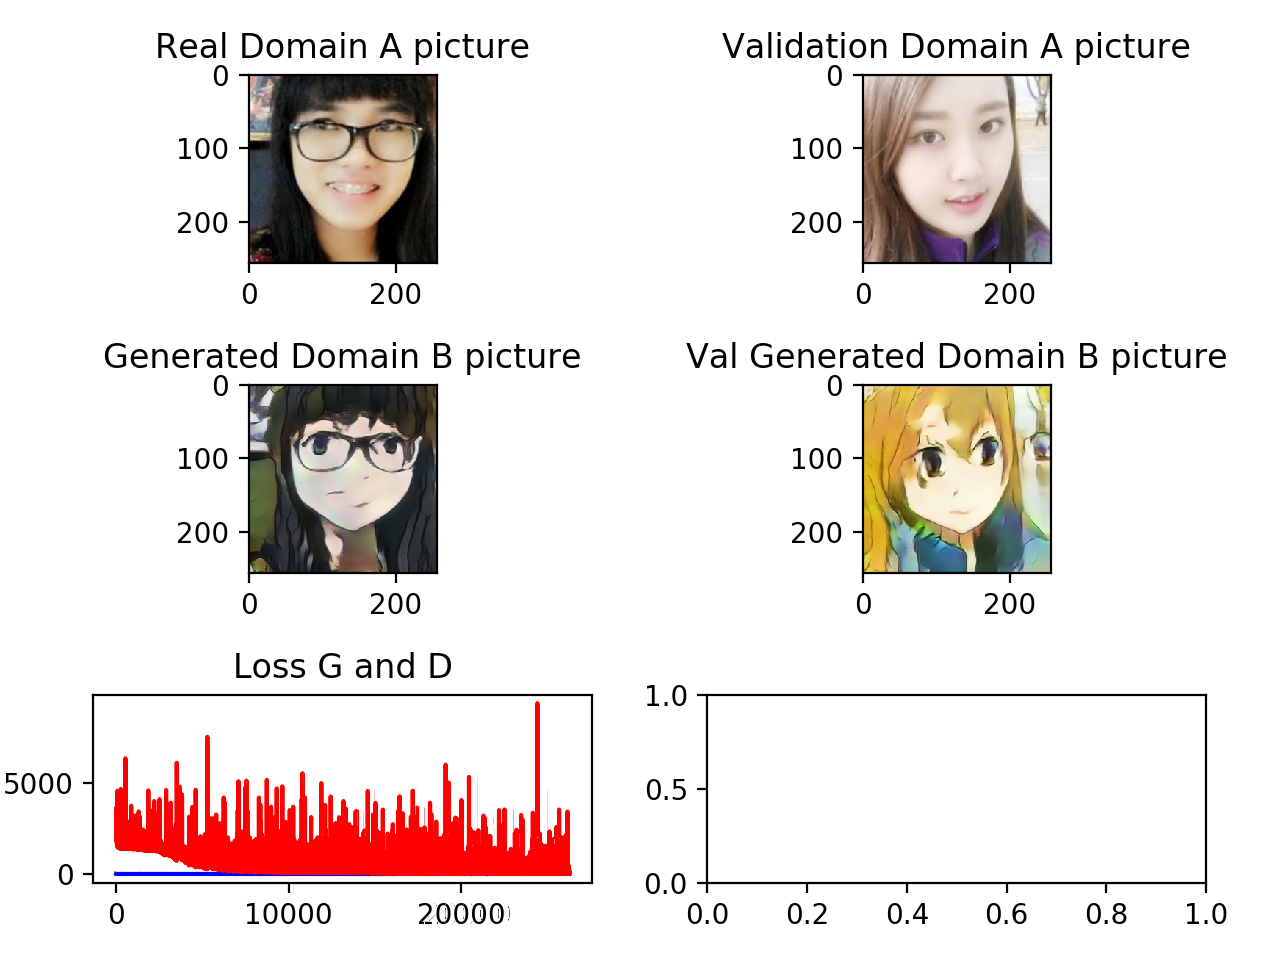

In [16]:
%matplotlib notebook
f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
real_pics[0].set_title("Real Domain A picture")
gen_pics[0].set_title("Generated Domain B picture")
loss_axis[0].set_title("Loss G and D")
real_pics[1].set_title("Validation Domain A picture")
gen_pics[1].set_title("Val Generated Domain B picture")
#real_pic.plot()
#gen_pic.plot()
loss_d = []
loss_g = []
loss_axis[0].plot(loss_d, list(range(len(loss_d))), 'b',
               loss_g, list(range(len(loss_g))), 'r')
plt.tight_layout()

In [17]:
model = UGATIT(in_channels=3, img_size=256, num_enc_blocks=3, num_enc_res_blocks=4, num_dec_upsample_blocks=2,
               num_dec_res_blocks=4, norm_type="instance", pad_type="reflection",
               local_discr_num_downsample=3, global_discr_num_downsample=5).cuda()

model.cuda();
model.train();
model.apply(init_weights_normal);
#model.load_state_dict(torch.load('/home/mpakhomov/Cycle_gan_pytorch/UGATIT_best_4.pth'))

In [18]:
def train_loop(num_epochs, train_dataloader, val_dataloader, model):
    optimizer_G = optim.Adam(list(model.G_AB.parameters()) + list(model.G_BA.parameters()), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(list(model.D_AG.parameters()) + list(model.D_AL.parameters()) + list(model.D_BG.parameters()) + \
                             list(model.D_BL.parameters()), lr=0.0001, betas=(0.5, 0.999))
    lr = 0.0001
    for epoch in range(num_epochs):

        if epoch % 20 == 19:
            torch.save(model.state_dict(), '/home/dpakhom1/Cycle_gan_pytorch/'+ str(epoch + 1) + "_UGATIT_new_dataset.pth")
            
        if epoch > 100:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(lr - 0.00001, 0)
            for param_group in optimizer_D.param_groups:
                param_group['lr'] = max(lr - 0.00001, 0)
                
        for idx, data in enumerate(train_dataloader):
            domain_A, domain_B = data["A"].cuda(), data["B"].cuda()
            
            #fake_B, cycle_BA, fake_A, cycle_AB = calc_Gs_outputs(G1, G2, domain_A, domain_B)
            fake_A, fake_B = model.forward(domain_A, domain_B)
            #print(fake_A)
            
            #set_requires_grad([model.D_AG, model.D_AL, model.D_BG, model.D_BL], False)
            optimizer_G.zero_grad()
            loss_G = model.backward_Gs(domain_A, domain_B)
            loss_g.append(loss_G.item())
            
            optimizer_G.step()
            
            model.G_AB.apply(model.rho_clipper)
            model.G_BA.apply(model.rho_clipper)
            
            #if idx % 5 == 4:
            #set_requires_grad([model.D_AG, model.D_AL, model.D_BG, model.D_BL], True)
            optimizer_D.zero_grad()
            loss_D = model.backward_Ds(domain_A, domain_B)
            loss_d.append(loss_D)
            optimizer_D.step()
            
            if idx % 200 == 199:
                print("Epoch: ", epoch + 1, "\n", "Gen loss: ", loss_G, "\n", "Discr loss: ", loss_D)

            if idx % 20 == 19:
                with torch.no_grad():
                    real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
                    #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                    real_pics[0].relim()
                    real_pics[0].autoscale_view()
                    real_pics[0].figure.canvas.draw()
                    model.G_AB.eval()
                    output, _ = model.G_AB(domain_A)
                    output = (((np.transpose(torch.squeeze(output.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                    #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                    gen_pics[0].imshow(output)
                    gen_pics[0].relim()
                    gen_pics[0].autoscale_view()
                    gen_pics[0].figure.canvas.draw()
                    model.G_AB.train()
                    
                    loss_axis[0].lines[0].set_xdata(list(range(len(loss_d))))
                    loss_axis[0].lines[0].set_ydata(loss_d)
                    loss_axis[0].lines[1].set_xdata(list(range(len(loss_g))))
                    loss_axis[0].lines[1].set_ydata(loss_g)
                    loss_axis[0].relim()
                    loss_axis[0].autoscale_view()
                    loss_axis[0].figure.canvas.draw()
            if idx % 10 == 9:
                for data in val_dataloader:
                    with torch.no_grad():
                        domain_A = data["A"].cuda()
                        real_pics[1].imshow(tensor_to_image(torch.squeeze(data["A"])))
                        #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                        real_pics[1].relim()
                        real_pics[1].autoscale_view()
                        real_pics[1].figure.canvas.draw()
                        model.G_AB.eval()
                        fake_B, _ = model.G_AB(domain_A)
                        output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                        #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                        gen_pics[1].imshow(output)
                        gen_pics[1].relim()
                        gen_pics[1].autoscale_view()
                        gen_pics[1].figure.canvas.draw()
                        model.G_AB.train()
                    break

In [ ]:
train_loop(200, train_dataloader, val_dataloader, model)

/home/mpakhomov/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  1 
 Gen loss:  tensor(1538.8845, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(3.4907, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 
 Gen loss:  tensor(1451.0114, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(3.9975, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 
 Gen loss:  tensor(1486.4957, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.5603, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 
 Gen loss:  tensor(1386.2152, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.3400, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 
 Gen loss:  tensor(1351.8545, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.6203, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 
 Gen loss:  tensor(1379.4353, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.0891, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 
 Gen loss:  tensor(1356.0975, device='cuda:0', grad_fn=<AddBackward0>) 

Epoch:  4 
 Gen loss:  tensor(191.0859, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(1.7968, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4 
 Gen loss:  tensor(230.9753, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.4380, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4 
 Gen loss:  tensor(117.1621, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.4971, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4 
 Gen loss:  tensor(116.1615, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.3244, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4 
 Gen loss:  tensor(94.4762, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.5150, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4 
 Gen loss:  tensor(439.8052, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(3.3509, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4 
 Gen loss:  tensor(410.6935, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr 

Epoch:  7 
 Gen loss:  tensor(45.5857, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7 
 Gen loss:  tensor(243.8156, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.0362, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7 
 Gen loss:  tensor(319.0537, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.7331, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7 
 Gen loss:  tensor(36.3221, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.3714, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7 
 Gen loss:  tensor(38.5872, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.4140, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7 
 Gen loss:  tensor(79.1260, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(1.7588, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7 
 Gen loss:  tensor(1460.0271, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr lo

In [20]:
torch.save(model.state_dict(), "/home/dpakhom1/Cycle_gan_pytorch/UGATIT_best_4.pth")